We use the two different subsets of ShapeStacks during training (cf. Table 1), each one containing an equal amount of stable and unstable images. Both types of violations (VCOM and VPSF, cf. Section 3.2) are evenly represented among unstable images.  

During training, we augment the training images by randomising colours, varying aspect-ratios, and applying random cropping, vertical flipping and minimal in-plane rotation. We ensure that all data augmentations still yield physically plausible, upright towers.

In [13]:
# %pip install opencv-python tensorflow pandas matplotlib gdown
# %pip install scikit-learn
## If OpenCV does not work - Run the following command in the terminal
# sudo apt-get install python3-opencv

In [1]:
import gdown
import zipfile
import os

if not os.path.exists('COMP90086_2024_Project_train'):
    # Get training data
    file_id = '1VzGFCjc-XAHNK0ujkuGEg7E-idV7QhDv'
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, 'train.zip', quiet=False)
    
    # Unzip data
    with zipfile.ZipFile('train.zip', 'r') as zip_ref:
        zip_ref.extractall('COMP90086_2024_Project_train')  # specify your extraction directory

    # Delete zip file
    os.remove('train.zip')

In [2]:
import os
import cv2
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# Define your image size and channels
imsize = 224

In [98]:
# Function to get filenames and labels
def getFilenames(rootpath, file, ds = 'train'):
    # Lists to store file data
    filenames = []
    labels = []
    # List file parameters
    meta_list_file = os.path.join(rootpath, file)
    with open(meta_list_file) as f:
        meta_list = f.read().split('\n')
        meta_list.pop(0) # remove trailing empty line
        meta_list.pop(-1)

    for i, meta in enumerate(meta_list):
        if (i+1) % 1000 == 0 or i+1 == len(meta_list):
            print("%s / %s : %s" % (i+1, len(meta_list), meta))
        rec = meta.split(',')
        filenames.append(os.path.join(rootpath, ds, rec[0]+'.jpg'))
        if ds == 'train':
            try:
                # label semantics: 0 = stable | 1 = unstable
                sem = [0. if int(rec[4]) == 0 else 1.]
                labels.extend(sem)
            except:
                print(rec)
    return filenames, labels

In [101]:
trainPath = 'COMP90086_2024_Project_train'
trainFile = 'train.csv'

filenames, labels = getFilenames(trainPath, trainFile)
labels = np.array(labels).astype(int).tolist()
labels = [0 if i==1 else 1 for i in labels]
pd.DataFrame(labels).value_counts()

1000 / 7680 : 131545,2,2,5,0,1,5
2000 / 7680 : 266662,2,1,2,1,1,1
3000 / 7680 : 394858,1,2,5,0,1,5
4000 / 7680 : 523454,1,1,6,1,2,2
5000 / 7680 : 661586,2,2,4,1,2,2
6000 / 7680 : 789513,1,2,6,1,1,1
7000 / 7680 : 912435,2,2,6,2,1,2
7680 / 7680 : 999668,1,2,4,1,2,3


0
0    5760
1    1920
Name: count, dtype: int64

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm  # For progress bar
# Set device for training (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [103]:
# Function to augment the images
def augment_image_cv2(image):
    # Random horizontal flip
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
    
    # Random rotation
    angle = random.uniform(-10, 10)
    h, w = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    image = cv2.warpAffine(image, rotation_matrix, (w, h))
    
    # Random cropping and resizing back to target size
    crop_size = random.uniform(0.8, 1.0)  # Crop 80% to 100% of the image
    new_h, new_w = int(h * crop_size), int(w * crop_size)
    y, x = random.randint(0, h - new_h), random.randint(0, w - new_w)
    image = image[y:y+new_h, x:x+new_w]
    image = cv2.resize(image, (2 * imsize, imsize))
    
    # Random brightness adjustment
    brightness_factor = random.uniform(0.8, 1.2)
    image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)
    
    return image
    
    # Combine the original and augmented data
    balanced_filenames = majority_filenames + minority_filenames + augmented_minority_filenames
    balanced_labels = [majority_class] * len(majority_filenames) + [minority_class] * len(minority_filenames) + augmented_minority_labels

    return balanced_filenames, balanced_labels

In [104]:
# Function to balance dataset by augmenting the minority class and saving augmented images
def balance_classes(filenames, labels, output_folder='augmented_images'):
    """ Balance the dataset by augmenting the minority class and saving augmented images """
    class_counts = Counter(labels)
    majority_class = max(class_counts, key=class_counts.get)
    minority_class = min(class_counts, key=class_counts.get)

    # Create output folder for augmented images
    os.makedirs(output_folder, exist_ok=True)

    # Separate filenames by class
    majority_filenames = [fname for fname, label in zip(filenames, labels) if label == majority_class]
    minority_filenames = [fname for fname, label in zip(filenames, labels) if label == minority_class]

    # Calculate how many more samples are needed to balance the dataset
    difference = class_counts[majority_class] - class_counts[minority_class]
    augmented_minority_filenames = []
    augmented_minority_labels = []

    # Augment the minority class images and save them to the new folder
    while difference > 0:
        for fname in minority_filenames:
            image = cv2.imread(fname)
            augmented_image = augment_image_cv2(image)

            # Create a new filename for the augmented image
            base_name = os.path.basename(fname)
            new_filename = os.path.join(output_folder, f'aug_{difference}_{base_name}')

            # Save the augmented image
            cv2.imwrite(new_filename, augmented_image)

            augmented_minority_filenames.append(new_filename)  # Store the new filename
            augmented_minority_labels.append(minority_class)
            difference -= 1
            if difference <= 0:
                break

    # Combine the original and augmented data
    balanced_filenames = majority_filenames + minority_filenames + augmented_minority_filenames
    balanced_labels = [majority_class] * len(majority_filenames) + [minority_class] * len(minority_filenames) + augmented_minority_labels

    return balanced_filenames, balanced_labels

In [105]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and validation sets
train_filenames, val_filenames, train_labels, val_labels = train_test_split(
    filenames, labels, test_size=0.3, stratify=labels, random_state=42)

# Balance the training dataset by augmenting the minority class
train_balanced_filenames, train_balanced_labels = balanced_filenames, balanced_labels = balance_classes(train_filenames, train_labels)

print(f'Training dataset:\t\t {Counter(train_labels)}')
print()
print(f'Balanced Training dataset:\t {Counter(train_balanced_labels)}')
print(f'Validation dataset:\t\t {Counter(val_labels)}')

Training dataset:		 Counter({0: 4032, 1: 1344})

Balanced Training dataset:	 Counter({0: 4032, 1: 4032})
Validation dataset:		 Counter({0: 1728, 1: 576})


In [106]:
# Custom Dataset class using OpenCV for image loading
class CustomCV2Dataset(Dataset):
    def __init__(self, filenames, labels):
        self.filenames = filenames
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load image using OpenCV
        image = cv2.imread(self.filenames[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        image = cv2.resize(image, (2 * imsize, imsize))  # Resize without augmentation

        # Convert the image to tensor and normalize
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Create datasets with balanced data
# train_dataset = CustomCV2Dataset(train_filenames, train_labels)
train_dataset = CustomCV2Dataset(train_balanced_filenames, train_balanced_labels)
val_dataset = CustomCV2Dataset(val_filenames, val_labels)  # Use the original validation data

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [107]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)  # Output: (16, 224, 224)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)  # Output: (32, 112, 112)
        
        # Flatten will adjust based on the calculated size
        self.flattened_size = self._get_flattened_size()
        self.fc1 = nn.Linear(self.flattened_size, 64)  # Adjusted size based on calculation
        self.fc2 = nn.Linear(64, 2)  # Output layer for 2 classes

    def _get_flattened_size(self):
        # Create a dummy tensor to calculate the flattened size
        with torch.no_grad():
            x = torch.zeros(1, 6, 224, 224)  # Example input with correct dimensions
            x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Max Pooling
            x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Max Pooling
            return x.numel()  # Get the number of elements in the output tensor

    def forward(self, x):
        x = x.contiguous().view(-1, 6, 224, 224)  # Reshape input
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Max Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Max Pooling
        x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
        x = self.fc1(x)  # First fully connected layer
        x = self.fc2(x)  # Final output layer
        return x

In [108]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Iterate over training data
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device).long()  # Move data to device
            
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize the model parameters
            
            running_loss += loss.item()  # Accumulate loss
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
            total += labels.size(0)  # Total samples
            correct += (predicted == labels).sum().item()  # Correct predictions

        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():  # No gradient calculation in validation
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device).long()
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        # Calculate validation loss and accuracy
        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [109]:
import matplotlib.pyplot as plt

# Function to plot loss and accuracy
def plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies, epochs):
    epochs_range = range(1, epochs + 1)
    
    # Plot Loss
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_losses, label='Validation Loss', color='orange')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [110]:
# Calculate class weights
class_counts = torch.tensor([1920, 5760], dtype=torch.float32)
class_weights = 1.0 / class_counts

# Assign class weights to the loss function
weights = class_weights.to(device)  # Move to device if using GPU

In [111]:
# Instantiate the model
model = CNN()
# Move the model to the appropriate device
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weights)  # Loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Training parameters
epochs = 10

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, validation_loader, criterion, optimizer, epochs)

Training Epoch 1/10: 100%|██████████| 252/252 [00:05<00:00, 48.32it/s]

Epoch [1/10], Loss: 0.5908, Accuracy: 0.6298


Validation Loss: 0.3763, Validation Accuracy: 0.7487


Training Epoch 2/10: 100%|██████████| 252/252 [00:05<00:00, 48.95it/s]

Epoch [2/10], Loss: 0.3501, Accuracy: 0.8059


Validation Loss: 0.3830, Validation Accuracy: 0.7457


Training Epoch 3/10: 100%|██████████| 252/252 [00:05<00:00, 48.86it/s]

Epoch [3/10], Loss: 0.3220, Accuracy: 0.8197


Validation Loss: 0.4160, Validation Accuracy: 0.7270


Training Epoch 4/10: 100%|██████████| 252/252 [00:05<00:00, 45.97it/s]

Epoch [4/10], Loss: 0.3063, Accuracy: 0.8265


Validation Loss: 0.3850, Validation Accuracy: 0.7383


Training Epoch 5/10: 100%|██████████| 252/252 [00:05<00:00, 46.14it/s]

Epoch [5/10], Loss: 0.2923, Accuracy: 0.8340


Validation Loss: 0.3912, Validation Accuracy: 0.7465


Training Epoch 6/10: 100%|██████████| 252/252 [00:05<00:00, 46.92it/s]

Epoch [6/10], Loss: 0.2772, Accuracy: 0.8349


Validation Loss: 0.3983, Validation Accuracy: 0.7361


Training Epoch 7/10: 100%|██████████| 252/252 [00:05<00:00, 47.08it/s]

Epoch [7/10], Loss: 0.2661, Accuracy: 0.8390


Validation Loss: 0.4179, Validation Accuracy: 0.7313


Training Epoch 8/10: 100%|██████████| 252/252 [00:05<00:00, 45.36it/s]


Epoch [8/10], Loss: 0.2547, Accuracy: 0.8457
Validation Loss: 0.4380, Validation Accuracy: 0.7101


Training Epoch 9/10: 100%|██████████| 252/252 [00:05<00:00, 49.14it/s]

Epoch [9/10], Loss: 0.2384, Accuracy: 0.8558


Validation Loss: 0.4902, Validation Accuracy: 0.6914


Training Epoch 10/10: 100%|██████████| 252/252 [00:04<00:00, 51.66it/s]

Epoch [10/10], Loss: 0.2209, Accuracy: 0.8642


Validation Loss: 0.4456, Validation Accuracy: 0.7166


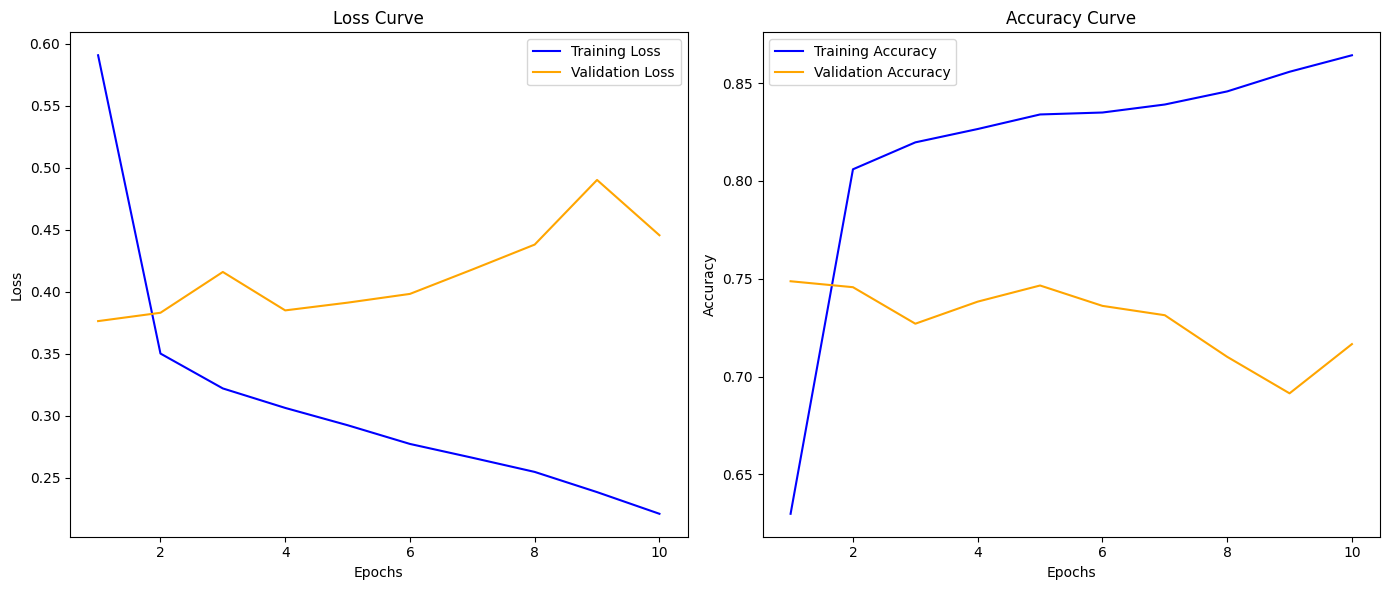

In [112]:
# Plot the loss and accuracy
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies, epochs)

In [113]:
if not os.path.exists('COMP90086_2024_Project_test'):
    # Get training data
    file_id = '1zGQl6K0JiGfHeIINz5go3pUrExnniB-d'
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, 'test.zip', quiet=False)

    # Unzip data
    with zipfile.ZipFile('test.zip', 'r') as zip_ref:
        tqdm(zip_ref.extractall('COMP90086_2024_Project_test'))  # specify your extraction directory

    # Delete zip file
    os.remove('test.zip')

In [114]:
testPath = 'COMP90086_2024_Project_test'
testFile = 'test.csv'

test_filenames, _ = getFilenames(testPath, testFile, 'test')

1000 / 1920 : 525774
1920 / 1920 : 999651


In [115]:
class TestDataset(Dataset):
    def __init__(self, filenames):
        self.filenames = filenames
        self.transform = transforms.Compose([
            transforms.ToTensor(),                     # Convert to tensor
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load image using OpenCV
        image = cv2.imread(self.filenames[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        image = cv2.resize(image, (2 * imsize, imsize))  # Resize the image

        # Convert the image to a tensor and normalize
        image = self.transform(image / 255.0)  # Normalize to [0, 1] range before converting to tensor

        return image

In [116]:
# Create test dataset and dataloader
test_dataset = TestDataset(test_filenames)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [117]:
# Set model to evaluation mode
model.eval()

# Store predictions
predictions = []

# No need to calculate gradients during inference
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        images = images.float()  # Ensure the input is of type float32
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the index of the highest score
        predictions.extend(predicted.cpu().numpy())  # Store the predictions

# Now `predictions` will contain the predicted labels for the test images


In [118]:
pd.Series(predictions).value_counts()

0    1600
1     320
Name: count, dtype: int64

In [121]:
test_path = os.path.join(testPath, testFile)
test_pred = pd.read_csv(test_path)
test_pred['stable_height'] = predictions
test_pred.set_index('id').to_csv('predictions.csv')